### Постановка задачи

Крупная авиакомпания хочет повысить эффективность своей работы за счет сокращения времени задержки прибытия внутренних рейсов в будущем году.

Сокращение времени задержки позволит снизить расходы компании и повысить ее привлекательность для клиентов.

Для анализа доступны данные о полетах за текущий год.

Задачи:
- определение факторов, влияющих на задержку рейсов в текущем году;
- прогнозировать задержку рейса для принятия соответствующих мер по сокращению задержки (при возможности).

Эксперты сообщили, что на задержку рейсов влияют разные типы факторов:
1. Некоторые факторы могут быть устранены или возможно снижение влияния данных факторов на задержку рейса (загруженность аэропорта, влияние типа аэропорта на задержу, проблемы с техобслуживанием или экипажем, чистка воздушного судна, загрузка багажа, заправка топливом).
2. Некоторые факторы выходят из под контроля авиакомпании и не могут быть устранены (погода, проблемы с судном, проблемы обеспечения безопасности).
3. Задержка судна в предыдущем рейсе не учитывается.
4. Опозданием считается задержка более 15 минут.

#### Загрузка и распаковка данных

In [50]:
from urllib.request import urlretrieve
from zipfile import ZipFile

ds_url = "https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip"
ds_zip_filename = "data/aa-domestic-delays-2018.csv.zip"
urlretrieve(ds_url, ds_zip_filename)

with ZipFile(ds_zip_filename, "r") as zObject:
    zObject.extractall(path="data")

#### Загрузка данных в Dataframe

In [51]:
import pandas as pd

orig_df = pd.read_csv("data/aa-domestic-delays-2018.csv")
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

### Признаки

Общие признаки:
- FL_NUM – номер рейса.
- ORIGIN  – код аэропорта отправления.
- DEST  – код аэропорта назначения.

Признаки вылета:
- PLANNED_DEP_DATETIME  – запланированные дата и время рейса.
- CRS_DEP_TIME  – запланированное время отправления.
- DEP_TIME  – фактическое время отправления.
- DEP_AFPH  – количество фактических вылетов в час. Данный признак показывает степень загруженности аэропорта отправления во время взлета.
- DEP_RFPH  – относительное количество вылетов в час. Данный признак показывает степень загруженности аэропорта отправления во время взлета.
- TAXI_OUT  – время, прошедшее между выездом самолета на взлетную полосу аэропорта отправления и отрывом колес самолета от земли.
- WHEELS_OFF  – момент времени, когда колеса самолета отрываются от земли.

Полетные признаки:
- CRS_ELAPSED_TIME – запланированное время, необходимое для полета.
- PCT_ELAPSED_TIME – отношение фактического времени полета к запланированному времени полета для измерения относительной скорости самолета.
- DISTANCE – расстояние между двумя аэропортами.

Признаки прибытия:
- CRS_ARR_TIME – запланированное время прибытия.
- ARR_AFPH – число фактических прибытия в час. Этот признак показывает степень загруженности аэропорта назначения во время посадки самолета.
- ARR_RFPH – относительное число прибытий в час. Этот признак показывает степень загруженности аэропорта назначения во время посадки самолета.
- DEP_DELAY – суммарная задержка отправления в минутах.
- ARR_DELAY – суммарная задержка прибытия в минутах, которая включает следующие параметры.
    - CARRIER_DELAY (целевая переменная) – задержка в минутах, вызванная обстоятельствами, находящимися в пределах контроля авиакомпании.
    - WEATHER_DELAY – задержка в минутах, вызванная метеорологическими условиями.
    - NAS_DELAY – задержка в минутах, предусмотренная национальной авиационной системой.
    - SECURITY_DELAY – задержка в минутах, вызванная процедурами обеспечения безопасности.
    - LATE_AIRCRAFT_DELAY – задержка в минутах, вызванная предыдущим рейсом того же самолета, который прибыл с опозданием.

#### Подготовка данных и конструирование признаков

1. Преобразование даты (PLANNED_DEP_DATETIME) из строки в datetime.
2. Получение месяца и дня недели вылета из даты для учета сезонности и особенностей дня недели (DEP_MONTH и DEP_DOW).
3. Удаление столбца с датой (PLANNED_DEP_DATETIME).
4. Определение признака хаба для аэропортов вылета и назначения (ORIGIN_HUB и DEST_HUB).
5. Удаление лишних столбцов (FL_NUM, ORIGIN, DEST).
6. Удаление столбца с общим временем задержки прибытия, так как данные значения будут иметь сильное влияние на результат (ARR_DELAY).

In [52]:
df = orig_df.copy()
# Преобразование даты из строки в datetime
df["PLANNED_DEP_DATETIME"] = pd.to_datetime(df["PLANNED_DEP_DATETIME"])
# Получение месяца и дня недели вылета из даты для учета сезонности и особенностей дня недели
df["DEP_MONTH"] = df["PLANNED_DEP_DATETIME"].dt.month
df["DEP_DOW"] = df["PLANNED_DEP_DATETIME"].dt.dayofweek
# Удаление столбца с датой
df = df.drop(["PLANNED_DEP_DATETIME"], axis=1)
# Список аэропортов-хабов
hubs = ["CLT", "ORD", "DFW", "LAX", "MIA", "JFK", "LGA", "PHL", "PHX", "DCA"]
# Определение признака хаба для аэропортов вылета и назначения
is_origin_hub = df["ORIGIN"].isin(hubs)
is_dest_hub = df["DEST"].isin(hubs)
# Установка признака хаба для данных
df["ORIGIN_HUB"] = 0
df.loc[is_origin_hub, "ORIGIN_HUB"] = 1
df["DEST_HUB"] = 0
df.loc[is_dest_hub, "DEST_HUB"] = 1
# Удаление лишних столбцов
df = df.drop(["FL_NUM", "ORIGIN", "DEST"], axis=1)
# Удаление столбца с общим временем задержки прибытия, так как данные значения будут иметь сильное влияние на результат
df = df.drop(["ARR_DELAY"], axis=1)
df

CRS_DEP_TIME  DEP_TIME  DEP_DELAY   DEP_AFPH  DEP_RFPH  TAXI_OUT  \
0               1155    1149.0       -6.0  34.444444  0.956790      14.0   
1                705     700.0       -5.0  17.454545  0.242424      16.0   
2               1148    1145.0       -3.0  94.736842  0.947368      14.0   
3                825     824.0       -1.0  33.559322  0.860495      16.0   
4               1155    1147.0       -8.0  33.461538  0.929487      13.0   
...              ...       ...        ...        ...       ...       ...   
899522          1534    1530.0       -4.0  35.357143  0.822259      20.0   
899523          1751    1757.0        6.0  71.818182  1.040843      18.0   
899524          2015    2010.0       -5.0  63.272727  1.193825      36.0   
899525          1300    1323.0       23.0  70.843373  0.770037      11.0   
899526          1435    1443.0        8.0  19.411765  0.924370       8.0   

        WHEELS_OFF  CRS_ELAPSED_TIME  PCT_ELAPSED_TIME  DISTANCE  ...  \
0           1203.0             219.0          0.963470    1192.0  ...   
1            716.0             171.0          0.918129    1192.0  ...   
2           1159.0             212.0          0.971698    1558.0  ...   
3            840.0             271.0          0.918819    1558.0  ...   
4           1200.0              99.0          0.969697     331.0  ...   
...            ...               ...               ...       ...  ...   
899522      1550.0             100.0          0.990000     331.0  ...   
899523      1815.0             181.0          0.972376     936.0  ...   
899524      2046.0             112.0          1.142857     511.0  ...   
899525      1334.0              50.0          0.820000     130.0  ...   
899526      1451.0              71.0          0.830986     130.0  ...   

        ARR_RFPH  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0       0.854573            0.0            0.0        0.0             0.0   
1       0.731707            0.0            0.0        0.0             0.0   
2       1.092437            0.0            0.0        0.0             0.0   
3       0.867379            0.0            0.0        0.0             0.0   
4       1.006803            0.0            0.0        0.0             0.0   
...          ...            ...            ...        ...             ...   
899522  0.837945            0.0            0.0        0.0             0.0   
899523  0.697674            0.0            0.0        0.0             0.0   
899524  0.482897            0.0            0.0        0.0             0.0   
899525  0.888031            0.0            0.0        0.0             0.0   
899526  1.011905            0.0            0.0        0.0             0.0   

        LATE_AIRCRAFT_DELAY  DEP_MONTH  DEP_DOW  ORIGIN_HUB  DEST_HUB  
0                       0.0          1        0           1         1  
1                       0.0          1        0           1         1  
2                       0.0          1        0           0         1  
3                       0.0          1        0           1         0  
4                       0.0          1        0           1         1  
...                     ...        ...      ...         ...       ...  
899522                  0.0         12        0           1         1  
899523                  0.0         12        0           1         1  
899524                  0.0         12        0           1         0  
899525                  0.0         12        0           1         0  
899526                  0.0         12        0           0         1  

[899527 rows x 22 columns]

#### Формирование тестовой и обучающей выборок данных

1. Задание фиксированного случайного состояния для воспроизводимости результатов (rand = 9).
2. Выделение признака, который модель должна предсказать (CARRIER_DELAY).
3. Формирование множества признаков, на основе которых модель будет обучаться (удаление столбца CARRIER_DELAY).
4. Формирование выборок (85 % обучающая, 15 % тестовая).
5. Создание классов для классификаторов в виде двоичных меток (опоздание свыше 15 минут – 1, иначе – 0).

In [53]:
from sklearn.model_selection import train_test_split

# Задание фиксированного случайного состояния для воспроизводимости результатов
rand = 9
# Выделение признака, который модель должна предсказать
y = df["CARRIER_DELAY"]
# Формирование множества признаков, на основе которых модель будет обучаться (удаление столбца с y)
X = df.drop(["CARRIER_DELAY"], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.15, random_state=rand
)
# Создание классов для классификаторов в виде двоичных меток (опоздание свыше 15 минут - 1, иначе - 0)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

display(X_train)
display(y_train_reg)
display(y_train_class)
X_train.info()

CRS_DEP_TIME  DEP_TIME  DEP_DELAY    DEP_AFPH  DEP_RFPH  TAXI_OUT  \
31121            845     842.0       -3.0   16.842105  0.443213      21.0   
633500          1315    1316.0        1.0    4.918033  0.983607       9.0   
747737          1710    1704.0       -6.0   55.555556  1.028807      14.0   
298943          1840    1920.0       40.0   28.200000  0.587500      18.0   
843932          1830    1822.0       -8.0   28.846154  0.901442      13.0   
...              ...       ...        ...         ...       ...       ...   
720822          1359    1410.0       11.0   53.239437  0.995130      26.0   
459253          2209    2207.0       -2.0   80.689655  1.021388      16.0   
711294           530     523.0       -7.0   12.452830  0.830189      17.0   
872796           709     706.0       -3.0  120.000000  1.030043      12.0   
516478          1925    2030.0       65.0   14.880000  1.352727       8.0   

        WHEELS_OFF  CRS_ELAPSED_TIME  PCT_ELAPSED_TIME  DISTANCE  ...  \
31121        903.0             106.0          0.886792     331.0  ...   
633500      1325.0             121.0          1.107438     624.0  ...   
747737      1718.0              67.0          1.074627     304.0  ...   
298943      1938.0             161.0          0.888199     852.0  ...   
843932      1835.0             215.0          0.930233    1192.0  ...   
...            ...               ...               ...       ...  ...   
720822      1436.0             147.0          1.006803     814.0  ...   
459253      2223.0              86.0          0.918605     413.0  ...   
711294       540.0             119.0          0.957983     666.0  ...   
872796       718.0             169.0          1.295858    1120.0  ...   
516478      2038.0             135.0          0.977778     761.0  ...   

          ARR_AFPH  ARR_RFPH  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
31121    85.333333  1.145414            0.0        0.0             0.0   
633500  111.891892  1.286114            0.0        0.0             0.0   
747737   17.288136  0.751658            0.0        0.0             0.0   
298943   38.780488  1.157627           22.0        0.0             0.0   
843932   90.810811  1.121121            0.0        0.0             0.0   
...            ...       ...            ...        ...             ...   
720822   25.000000  1.136364            0.0        0.0             0.0   
459253    2.352941  1.176471            0.0        0.0             0.0   
711294   37.500000  0.892857            0.0        0.0             0.0   
872796   12.336449  0.850790            0.0       47.0             0.0   
516478   93.442623  1.112412            0.0        0.0             0.0   

        LATE_AIRCRAFT_DELAY  DEP_MONTH  DEP_DOW  ORIGIN_HUB  DEST_HUB  
31121                   0.0          1        6           1         1  
633500                  0.0          9        4           0         1  
747737                  0.0         10        1           1         0  
298943                  0.0          5        5           0         1  
843932                  0.0         12        5           1         1  
...                     ...        ...      ...         ...       ...  
720822                  0.0         10        4           1         0  
459253                  0.0          7        6           1         0  
711294                  0.0         10        1           0         1  
872796                  0.0         12        3           1         0  
516478                 62.0          7        0           0         1  

[764597 rows x 21 columns]

31121     0.0
633500    0.0
747737    0.0
298943    0.0
843932    0.0
         ... 
720822    0.0
459253    0.0
711294    0.0
872796    0.0
516478    0.0
Name: CARRIER_DELAY, Length: 764597, dtype: float64

31121     0
633500    0
747737    0
298943    0
843932    0
         ..
720822    0
459253    0
711294    0
872796    0
516478    0
Name: CARRIER_DELAY, Length: 764597, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764597 entries, 31121 to 516478
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CRS_DEP_TIME         764597 non-null  int64  
 1   DEP_TIME             764597 non-null  float64
 2   DEP_DELAY            764597 non-null  float64
 3   DEP_AFPH             764597 non-null  float64
 4   DEP_RFPH             764597 non-null  float64
 5   TAXI_OUT             764597 non-null  float64
 6   WHEELS_OFF           764597 non-null  float64
 7   CRS_ELAPSED_TIME     764597 non-null  float64
 8   PCT_ELAPSED_TIME     764597 non-null  float64
 9   DISTANCE             764597 non-null  float64
 10  CRS_ARR_TIME         764597 non-null  int64  
 11  ARR_AFPH             764597 non-null  float64
 12  ARR_RFPH             764597 non-null  float64
 13  WEATHER_DELAY        764597 non-null  float64
 14  NAS_DELAY            764597 non-null  float64
 15  SECURITY_DELA

#### Определение линейной корреляции признаков с целевым признаком с помощью корреляции Пирсона

Существует сильная прямая корреляция между целевым признаком CARRIER_DELAY и признаком DEP_DELAY (70 %).

Но это не значит, что в данных отсутствуют нелинейные зависимости, или что совокупность признаков не оказывает влияние на значение целевого признака.

In [54]:
corr = df.corr()
abs(corr["CARRIER_DELAY"]).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

#### Использование регрессионных моделей для предсказания задержки рейса

1. Линейная регрессия (linear).
2. Полиномиальная регрессия (linear_poly).
3. Полиномиальная регрессия без квадратичных членов (linear_interact).
4. Гребневая регрессия (ridge).
5. Дерево решений (decision_tree).
6. k ближайших соседей (kNN).
7. Случайный лес (random_forest).
8. Многослойный персептрон (mlp).

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import linear_model, tree, neighbors, ensemble, neural_network

reg_models = {
    # Линейные модели
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2, interaction_only=False),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
            memory=None
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2, interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
            memory=None
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},
    # Деревья
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(max_depth=7, random_state=rand)
    },
    # Ближайшие соседи
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    # Ансамблевые методы
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=rand, n_jobs=-1
        )
    },
    # Нейронные сети
    "mlp": {
        "model": neural_network.MLPRegressor(
            hidden_layer_sizes=(21,),
            max_iter=500,
            early_stopping=True,
            random_state=rand,
        )
    },
}

#### Обучение и оценка регрессионных моделей

Метрики: 
- RMSE – корень из средней квадратичной ошибки.
- MAE – средняя абсолютная ошибка.
- R-квадрат – коэффициент детерминации.

In [58]:
import math
from sklearn import metrics

for model_name in reg_models.keys():
    print(f'Model: {model_name}')
    fitted_model = reg_models[model_name]["model"].fit(
        X_train.values, y_train_reg.to_numpy().ravel()
    )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]["fitted"] = fitted_model
    reg_models[model_name]["preds"] = y_test_pred
    reg_models[model_name]["RMSE_train"] = math.sqrt(
        metrics.mean_squared_error(y_train_reg, y_train_pred)
    )
    reg_models[model_name]["RMSE_test"] = math.sqrt(
        metrics.mean_squared_error(y_test_reg, y_test_pred)
    )
    reg_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train_reg, y_train_pred)
    reg_models[model_name]["MAE_test"] = metrics.mean_absolute_error(
        y_test_reg, y_test_pred
    )
    reg_models[model_name]["R2_test"] = metrics.r2_score(y_test_reg, y_test_pred)

Model: linear
Model: linear_poly
Model: linear_interact
Model: ridge
Model: decision_tree
Model: knn
Model: random_forest
Model: mlp


#### Вывод оценки в виде таблицы

In [59]:
reg_metrics = pd.DataFrame.from_dict(reg_models, "index")[
    ["RMSE_train", "RMSE_test", "MAE_train", "MAE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(
    cmap="plasma", low=0.3, high=1, subset=["MAE_train", "MAE_test", "R2_test"]
)

Наилучший результат показали модели с типом черный ящик и аквариумные модели.

#### Определение сбалансированности выборки для классификации

In [ ]:
y_train_class[y_train_class == 1].shape[0] / y_train_class.shape[0]

0.061283264255549

Выборка данных имеет сильный дисбаланс в сторону отрицательного класса (y=0).

Для решения данной проблемы используется гиперпараметр class_weight="balanced" во многих моделях классификации.

#### Использование классификаторов для предсказания задержки рейса

1. Логистическая регрессия (logistic).
2. Гребневая классификация (ridge).
3. Дерево решений (decision_tree).
4. k ближайших соседей (knn).
5. Наивный Байес (naive_bayes).
6. Градиентно-бустированные деревья (gradient_boosting).
7. Случайный лес (random_forest).
8. Многослойный персептрон (mlp).

Сбалансированность выборки: 0,061. Использование гиперпараметра class_weight="balanced" позволяет адаптировать модели к данной особенности данных.

In [ ]:
from sklearn import naive_bayes

class_models = {
    # Линейные модели
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {
        "model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")
    },
    # Дерево
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=rand)
    },
    # Ближайшие соседи
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    # Наивный Байес
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    # Ансамблевые методы
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=rand
        )
    },
    # Нейронные сети
    "mlp": {
        "model": make_pipeline(
            StandardScaler(),
            neural_network.MLPClassifier(
                hidden_layer_sizes=(7,),
                max_iter=500,
                early_stopping=True,
                random_state=rand,
            ),
            memory=None
        )
    },
}

#### Обучение и оценка классификаторов

Метрики:
- Accuracy – верность/аккуратность.
- Recall – полнота.
- ROC AUC – площадь под ROC-кривой.
- F1-мера.
- MCC – коэффициент корреляции Мэтьюса.

In [31]:
import numpy as np

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    fitted_model = class_models[model_name]["model"].fit(
        X_train.values,
        y_train_class.to_numpy().ravel(),
    )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_prob = fitted_model.predict_proba(X_test.values)[:, 1]
    y_test_pred = fitted_model.predict(X_test.values)

    class_models[model_name]["fitted"] = fitted_model
    class_models[model_name]["probs"] = y_test_prob
    class_models[model_name]["preds"] = y_test_pred

    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train_class, y_train_pred
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test_class, y_test_pred
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train_class, y_train_pred
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test_class, y_test_pred
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test_class, y_test_prob
    )
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test_class, y_test_pred
    )

Model: logistic


/Users/user/Projects/python/ckexp/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: ridge


/Users/user/Projects/python/ckexp/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


#### Вывод оценки в виде таблицы

In [32]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_train",
        "Accuracy_test",
        "Recall_train",
        "Recall_test",
        "ROC_AUC_test",
        "F1_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma", low=0.3, high=1, subset=["Accuracy_train", "Accuracy_test"]
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=["Recall_train", "Recall_test", "ROC_AUC_test", "F1_test", "MCC_test"],
)

Использование различных меток позволяют оценить качество моделей классификации с точки зрения различных свойств (точность и полнота), что особенно важно при несбалансированной выборке.

#### Интерпретация результатов для моделей типа белый ящик

К моделям типа белого ящика в нашем случае относятся:
- Линейные модели: разные виды регрессии.
- Деревья решений.
- Метод ближайших соседей.
- Наивный Байес.

К аквариумным моделям (серый ящик) относятся ансамблевые модели: случайный лес, градиентный бустинг.

К моделям типа черного ящика относятся искусственные нейронные сети (MLP).


##### Линейные модели

Линейная регрессия

Коэффициенты и пересечение модели

In [33]:
coefs_lm = reg_models["linear"]["fitted"].coef_
intercept_lm = reg_models["linear"]["fitted"].intercept_
print("coefficients:\t%s" % coefs_lm)
print("intercept:\t%s" % intercept_lm)
print(
    "y = %0.2f + %0.4fX1 + %0.4fX2 + %0.3fX3 + ..."
    % (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2])
)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.86177932752649
y = -37.86 + 0.0045X1 + -0.0053X2 + 0.894X3 + ...


Вывод признаков и соответствующих им коэффициентам модели регрессии

In [34]:
coef_df = pd.DataFrame({"feature": X_train.columns.values.tolist(), "coef": coefs_lm})
display(coef_df)

feature       coef
0          CRS_DEP_TIME   0.004550
1              DEP_TIME  -0.005251
2             DEP_DELAY   0.894126
3              DEP_AFPH  -0.015296
4              DEP_RFPH  -0.469623
5              TAXI_OUT   0.125278
6            WHEELS_OFF  -0.000647
7      CRS_ELAPSED_TIME  -0.012624
8      PCT_ELAPSED_TIME  45.011289
9              DISTANCE   0.000676
10         CRS_ARR_TIME  -0.000370
11             ARR_AFPH   0.000548
12             ARR_RFPH   0.373867
13        WEATHER_DELAY  -0.906364
14            NAS_DELAY  -0.674053
15       SECURITY_DELAY  -0.917411
16  LATE_AIRCRAFT_DELAY  -0.929844
17            DEP_MONTH  -0.039662
18              DEP_DOW  -0.017967
19           ORIGIN_HUB  -1.029129
20             DEST_HUB  -0.394935

Интерпретация признаков:
- Числовой признак (DEP_DELAY). Увеличение значения признака на 1 единицу увеличивает целевой признак на значение коэффициента в соответствующих единицах.
- Бинарный признак (ORIGIN_HUB). Если значение отрицательное, то истинное значение признака уменьшает целевой признак на значение коэффициента.
- Категориальные признаки (DEP_MONTH). При условии кодирования категориальные признаки позволяют отслеживать влияние отдельных признаков на целевой признак.

In [ ]:
y_train_class[y_train_class == 1].shape[0] / y_train_class.shape[0]

0.061283264255549

Получение сведений о значимости признаков средствами библиотеки statsmodels

In [ ]:
import statsmodels.api as sm

linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
summary_df = linreg_mdl.summary2().tables[1]
summary_df = (
    summary_df.drop(["const"]).reset_index().rename(columns={"index": "feature"})
)
summary_df["t_abs"] = abs(summary_df["t"])
summary_df.sort_values(by="t_abs", ascending=False).style.background_gradient(
    cmap="plasma_r", low=0, high=0.1, subset=["P>|t|"]
).background_gradient(cmap="plasma_r", low=0, high=0.1, subset=["t_abs"])

Важными являются p-значение (P>|t|) и t-статистика (t_abs).

Из результатов видно, что самыми значимыми признаками модели являются:
- DEP_DELAY;
- LATE_AIRCRAFT_DELAY;
- WEATHER_DELAY;
- NAS_DELAY.

Гребневая регрессия

Интерпретация гребневой регрессии производится аналогично интерпретации линейной регрессии

In [69]:
coefs_ridge = reg_models["ridge"]["fitted"].coef_
coef_ridge_df = pd.DataFrame(
    {
        "feature": X_train.columns.values.tolist(),
        "coef_linear": coefs_lm,
        "coef_ridge": coefs_ridge,
    }
)
coef_ridge_df.style.background_gradient(cmap="viridis_r", low=0.3, high=0.2, axis=1)

Полиномиальная регрессия

Для интерпретации и оценки важности признаков полиномиальной регрессии рекомендуется использовать возможности библиотеки statsmodels, так как модель содержит 253 линейных члена.

In [38]:
display(
    reg_models["linear_poly"]["fitted"].get_params()["linearregression"].coef_.shape[0]
)
display(
    reg_models["linear_interact"]["fitted"]
    .get_params()["linearregression"]
    .coef_.shape[0]
)

253

232

Логистическая регрессия

Интерпретация логистической регрессии выполняется аналогично интерпретации линейной регрессии

Способ оценки важности признаков модели на основе логистической регрессии рассмотрен в предыдущей лекции

In [63]:
coefs_log = class_models["logistic"]["fitted"].coef_
intercept_log = class_models["logistic"]["fitted"].intercept_
print("coefficients:\t%s" % coefs_log)
print("intercept:\t%s" % intercept_log)
stdv = np.std(X_train, 0)
abs(
    coefs_log.reshape(
        21,
    )
    * stdv
).sort_values(ascending=False)

coefficients:	[[-0.00132811  0.00034525  0.15746107  0.00349808 -0.00215053 -0.00445293
   0.00029184 -0.05167613 -0.00175222  0.0055682  -0.00031922 -0.00757532
  -0.00273998 -0.15351444 -0.12133964 -0.00595224 -0.16451117 -0.01303235
  -0.0052911   0.00048854 -0.00206977]]
intercept:	[-0.00229272]


DEP_DELAY              6.969920
CRS_ELAPSED_TIME       4.101834
LATE_AIRCRAFT_DELAY    4.065346
DISTANCE               3.616141
NAS_DELAY              1.672065
WEATHER_DELAY          1.604186
CRS_DEP_TIME           0.665926
ARR_AFPH               0.267888
DEP_TIME               0.177772
CRS_ARR_TIME           0.168589
WHEELS_OFF             0.150765
DEP_AFPH               0.124024
DEP_MONTH              0.044475
TAXI_OUT               0.043947
DEP_DOW                0.010574
SECURITY_DELAY         0.009756
ARR_RFPH               0.001976
DEP_RFPH               0.001215
DEST_HUB               0.001007
ORIGIN_HUB             0.000238
PCT_ELAPSED_TIME       0.000185
dtype: float64

Дерево решений

В библиотеке scikit-learn для построения дерева решений используется алгоритм CART https://ru.wikipedia.org/wiki/CART_(алгоритм)

Оценочная функция, используемая алгоритмом CART, базируется на идее уменьшения неопределенности (неоднородности) в узле

Степень неопределенности вычисляется на основе индекса Gini-Simpson (Gini impurity)

Значение данного индекса позволяет рекурсивно расщеплять узел дерева в местах, где две ветви отличаются максимально

Визуализация дерева решений

Каждый узел содержит:
1. Условие
2. Значение индекса Джини-Симпсона
3. Количество наблюдений, которые поступили на вход
4. Количество наблюдения для левого и правого выходов

Если в узле отсутствует условие, то такой узел является листом дерева и содержит конечное решение

Путь от корня дерева до листа описывает некоторое правило дерева решений

/var/folders/yr/lls0svhd1fl_wljz9zn7kgzh0000gn/T/ipykernel_53152/2420969043.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


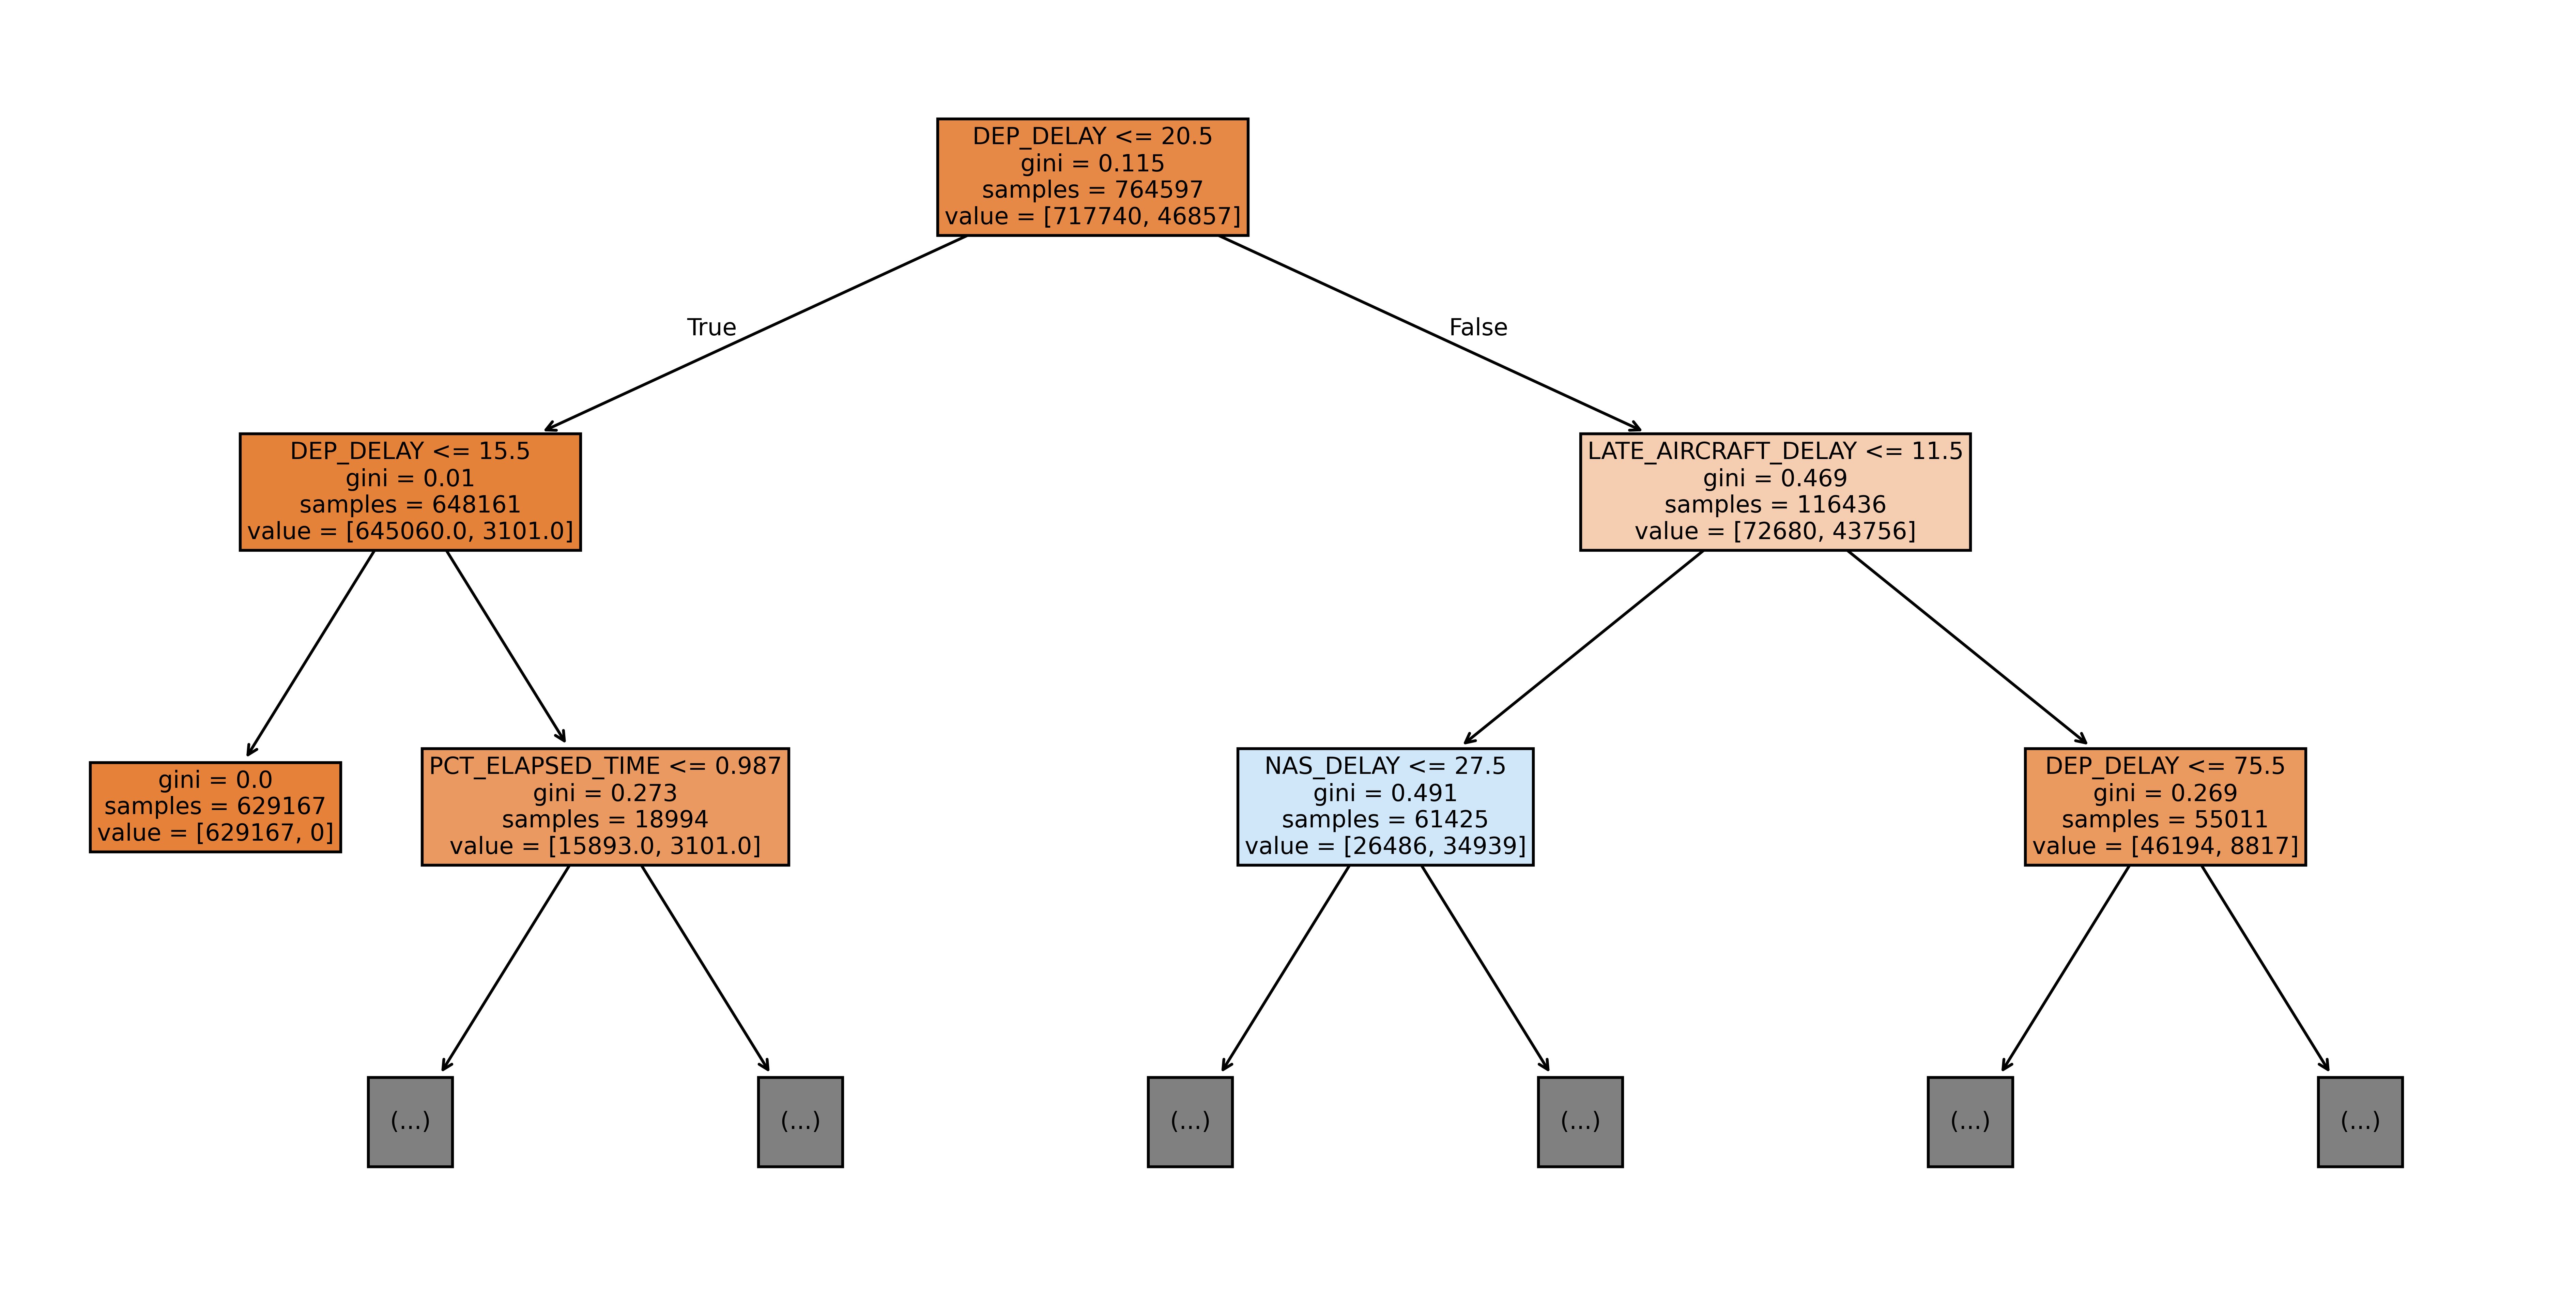

In [64]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=600)
tree.plot_tree(
    class_models["decision_tree"]["fitted"],
    feature_names=X_train.columns.values.tolist(),
    filled=True,
    max_depth=2,
)
fig.show()

В левом узле 629167 наблюдений отнесены к классу 0 (без опозданий)

Для данного листа можно сформулировать следующее правило: Если DEP_DELAY <= 15.5 Тогда 0

Аналогичное правило можно наблюдать в множестве правил, который можно извлечь из дерева решений:\
IF DEP_DELAY <= 20.5 AND DEP_DELAY <= 15.5 THEN class: 0

Вывод правил из модели дерева решений

In [40]:
text_tree = tree.export_text(
    class_models["decision_tree"]["fitted"],
    feature_names=X_train.columns.values.tolist(),
)
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

Библиотека позволяет получить важность признаков модели дерева решений

In [41]:
dt_imp_df = pd.DataFrame(
    {
        "feature": X_train.columns.values.tolist(),
        "importance": class_models["decision_tree"]["fitted"].feature_importances_,
    }
).sort_values(by="importance", ascending=False)
dt_imp_df

feature  importance
2             DEP_DELAY    0.527482
16  LATE_AIRCRAFT_DELAY    0.199153
8      PCT_ELAPSED_TIME    0.105381
13        WEATHER_DELAY    0.101649
14            NAS_DELAY    0.062732
15       SECURITY_DELAY    0.001998
9              DISTANCE    0.001019
7      CRS_ELAPSED_TIME    0.000281
5              TAXI_OUT    0.000239
6            WHEELS_OFF    0.000035
3              DEP_AFPH    0.000031
0          CRS_DEP_TIME    0.000000
19           ORIGIN_HUB    0.000000
18              DEP_DOW    0.000000
17            DEP_MONTH    0.000000
10         CRS_ARR_TIME    0.000000
12             ARR_RFPH    0.000000
11             ARR_AFPH    0.000000
1              DEP_TIME    0.000000
4              DEP_RFPH    0.000000
20             DEST_HUB    0.000000

k ближайших соседей

Интерпретировать модель на основе алгоритма k ближайших соседей можно только локально: на уровне отдельных наблюдений

Например, используем наблюдение с id = 721043 из тестовой выборки

Значения целевого признака для случая 721043:
- Фактическое ($y$): 1
- Предсказанное ($\hat{y}$): 0

In [67]:
display(X_test.loc[721043, :])
display(y_test_class[721043])
display(class_models["knn"]["preds"][X_test.index.get_loc(721043)])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64

1

0

Библиотека scikit-learn позволяет получить информацию об указанном количестве соседей (7) для некоторого элемента из тестовой выборки (id = 721043)

Первый элемент кортежа – расстояние от соседей в обучающей выборке до текущей точки в тестовой выборке

Второй элемент – идентификаторы соседей в тестовой выборке

In [43]:
class_models["knn"]["fitted"].kneighbors(
        X_test.loc[721043, :].values.reshape(1, 21), 7
)

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
         243.57211853, 259.61593993, 259.77507391]]),
 array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))

Данные о целевом признаке CARRIER_DELAY соседей для случая 721043 из обучающей выборки

In [44]:
y_train_class.iloc[[105172, 571912, 73409, 89450, 77474, 705972, 706911]]

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64

Можно сделать вывод, что значение $\hat{y}$ для случая 721043 было определено как мода от значений целевой переменной соседей.

Мода – одно или несколько значений во множестве наблюдений, которое встречается наиболее часто.

Наивный байесовский классификатор

Алгоритм обучения модели на основе наивного байесовского классификатора вычисляет априорные вероятности принадлежности наблюдения некоторому классу

$\hat{y} = P(y=1|X) = P(y=1) \prod^{n}_{i=1} P(x_{i} | y=1)$

$P(x_{i} | y=1) = \frac{ 1 }{ \sqrt{2 \pi \sigma_{i}^{2}}} e^{\frac{ (x_{i} \theta_{i})^2 }{ 2 \sigma^{2}_{i} }}$

Библиотека scikit-learn позволяет получить вероятности $P(y=0|X)$ и $P(y=1|X)$

In [46]:
class_models["naive_bayes"]["fitted"].class_prior_

array([0.93871674, 0.06128326])

Вероятность принадлежности классу 1 соответствует показателю сбалансированности выборки 

Для получения значения дисперсии $\sigma_{i}$ и среднего значения $\theta_{i}$ признаков в одном классе по сравнению с другим используются атрибуты var_ и theta_ 

Дисперсия

In [47]:
class_models["naive_bayes"]["fitted"].var_

array([[2.50123026e+05, 2.61324730e+05, 9.21572605e+02, 1.26123968e+03,
        2.08339528e-01, 9.58074414e+01, 2.62606651e+05, 6.30102550e+03,
        1.13475535e-02, 4.22470414e+05, 2.75433641e+05, 1.25314386e+03,
        3.48655340e-01, 1.11234714e+02, 1.91877186e+02, 2.80302201e+00,
        5.06561612e+02, 1.17346654e+01, 3.99122491e+00, 2.39015406e-01,
        2.34996222e-01],
       [2.60629652e+05, 2.96009867e+05, 1.19307931e+04, 1.14839167e+03,
        1.99929921e+00, 1.20404927e+02, 3.08568277e+05, 6.29066219e+03,
        1.38936741e-02, 4.10198938e+05, 3.28574000e+05, 1.09023147e+03,
        3.08997044e+00, 7.79140423e+01, 1.56184090e+02, 9.12112286e-01,
        2.11279954e+03, 1.02712368e+01, 4.02943162e+00, 1.77750796e-01,
        2.50208354e-01]])

Средние значения

In [48]:
class_models["naive_bayes"]["fitted"].theta_

array([[1.30740577e+03, 1.31006271e+03, 5.14196506e+00, 5.45864877e+01,
        1.09377996e+00, 1.87120810e+01, 1.33552258e+03, 1.70734929e+02,
        9.71131781e-01, 1.01824369e+03, 1.48438931e+03, 5.39873058e+01,
        1.09644787e+00, 7.39971299e-01, 2.85434558e+00, 2.41814585e-02,
        4.14674395e+00, 6.55045281e+00, 2.95035528e+00, 6.06800513e-01,
        6.24199571e-01],
       [1.41305545e+03, 1.48087887e+03, 8.45867640e+01, 6.14731036e+01,
        1.25429654e+00, 1.99378321e+01, 1.49409412e+03, 1.72229998e+02,
        9.83974416e-01, 1.04363666e+03, 1.54821862e+03, 4.26486417e+01,
        1.36373798e+00, 4.50733082e-01, 4.71991378e+00, 2.11281132e-02,
        1.40744819e+01, 6.73367907e+00, 3.04251232e+00, 7.69575517e-01,
        4.85391724e-01]])

Эти значения можно использовать для глобальной и локальной интерпретации модели.